# Exploring Pipelines and Evaluating Classification Models

## Why Pipeline?

Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 

Easily integrate transformers and estimators, plus cross validation!

<img src="images/grid_search_cross_validation.png" alt="cross validation image from sklearn's documentation" width=500>

Why might CV be good in instances when we're doing things like searching for optimal hyperparameters...?

- 


In [60]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve

First, let's start with the Titanic dataset from earlier today. Target is to predict `Survived`

In [22]:
# Grab, then explore data
df = pd.read_csv('data/titanic.csv')  

In [23]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
# Exploring numeric cols
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [26]:
# Exploring object cols
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Lundahl, Mr. Johan Svensson",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


### Baseline Understanding - Aka Model-less Baseline

In [28]:
# Exploring target distribution
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

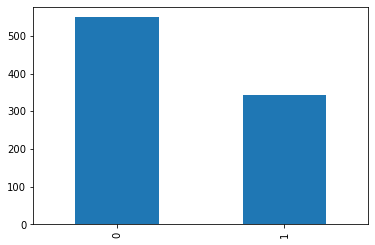

In [29]:
df['Survived'].value_counts().plot(kind='bar');

Evaluate - any thoughts on our model-less understanding?

- 


### Baseline Model

Let's find out how hard our problem is, by throwing things at it and seeing what sticks!

Biggest thing to think about - what types of columns need to be treated differently?

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [33]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [99]:
# First define our used columns
used_cols = [c for c in df.columns if c not in ['PassengerId', 'Name', 'Ticket', 'Survived']]

In [100]:
# Define our X and y

X = df[used_cols]
y = df['Survived']

# and train test split - to create our val holdout set!
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

In [101]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
815,1,male,NaN,0,0,0.0000,B102,S
877,3,male,19.0,0,0,7.8958,NaN,S
193,2,male,3.0,1,1,26.0000,F2,S
523,1,female,44.0,0,1,57.9792,B18,C
634,3,female,9.0,3,2,27.9000,NaN,S


In [102]:
# Setting up how to treat our columns
cat_cols = []
num_cols = []

for c in X.columns:
    # Grabbing numeric columns
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else: # And the rest are cat cols
        cat_cols.append(c)

In [103]:
# Check our work
print(f"Categorical Columns: {cat_cols}")
print(f"Numeric Columns: {num_cols}")

Categorical Columns: ['Sex', 'Cabin', 'Embarked']
Numeric Columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [104]:
# Now, setting up the preprocessing steps for each type of col
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

cat_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [105]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [106]:
# Just out of curiosity, let's see what this looks like 
X_tr_transformed = preprocessor.fit_transform(X_train)
X_tr_transformed.shape

(801, 146)

In [107]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(random_state=0))])

# Now - cross_validate!
output = cross_validate(clf_logreg, X_train, y_train,
                        scoring='roc_auc', 
                        return_train_score=True)

# Print our test scores to show average and a measure of variation
print(f"Average ROC-AUC: {output['test_score'].mean()} +/- {output['test_score'].std()}")

Average ROC-AUC: 0.8483750703758901 +/- 0.029623360682272795


Evaluate:

- Around .84 ROC-AUC - not bad!


### Try With Adjusted Hyperparameters

In [108]:
# Time for a new pipeline!
clf_bal = Pipeline(steps=[('preprocessor', preprocessor),  # don't need to change this!
                          ('classifier', LogisticRegression(random_state=0,
                                                            class_weight='balanced'))]) # new parameter!

# Now - cross_validate!
output = cross_validate(clf_bal, X_train, y_train,
                        scoring='roc_auc',
                        return_train_score=True,
                        return_estimator=True) # let's add this parameter to explore

# Test scores
print(f"Average ROC-AUC: {output['test_score'].mean()} +/- {output['test_score'].std()}")

Average ROC-AUC: 0.848243376386819 +/- 0.028871458115440757


Evaluate:

- Didn't seem to improve


### Validate

How does this perform on our holdout set?

First off - what might we want to check to evaluate our model?

- Accuracy, Precision, Recall, F1-Score
- Confusion Matrix
- ROC-AUC and ROC-AUC curve


Reference: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [109]:
# Can use the clf_bal we defined earlier, but need to fit it
clf_bal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('oh

In [110]:
# Grab predictions
hold_preds = clf_bal.predict(X_hold)

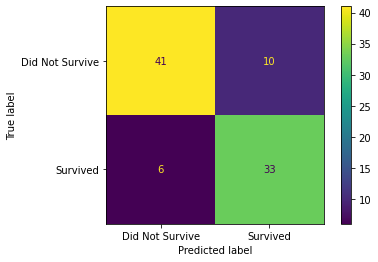

In [111]:
# First up, let's look at a confusion matrix for our holdout set
plot_confusion_matrix(clf_bal, X_hold, y_hold,
                      display_labels=['Did Not Survive', 'Survived'])

In [112]:
# All metrics on our holdout set...
print(f"Accuracy: {accuracy_score(y_hold, hold_preds)}")
print(f"Precision: {precision_score(y_hold, hold_preds)}")
print(f"Recall: {recall_score(y_hold, hold_preds)}")
print(f"F1-Score: {f1_score(y_hold, hold_preds)}")


Accuracy: 0.8222222222222222
Precision: 0.7674418604651163
Recall: 0.8461538461538461
F1-Score: 0.8048780487804877


In [113]:
# Can do ROC_AUC score... why is this different?
hold_proba = clf_bal.predict_proba(X_hold)[:, 1]
hold_proba

array([0.23303233, 0.1653119 , 0.17297791, 0.96076211, 0.76106148,
       0.58676947, 0.94117246, 0.94189687, 0.68794699, 0.78433073,
       0.15007382, 0.78153374, 0.19821928, 0.89280605, 0.96918186,
       0.78447784, 0.18879878, 0.30329673, 0.14096508, 0.39026877,
       0.35922737, 0.93566548, 0.19821715, 0.46732517, 0.74306252,
       0.9420326 , 0.15181808, 0.74263471, 0.84030406, 0.72551681,
       0.20948024, 0.72746047, 0.16761524, 0.68401248, 0.13920125,
       0.66141641, 0.1149498 , 0.29526249, 0.31427075, 0.16511603,
       0.41541755, 0.25021452, 0.16634331, 0.12153198, 0.90269435,
       0.1653631 , 0.1653631 , 0.96646084, 0.23389192, 0.39561871,
       0.5866394 , 0.71150023, 0.88884145, 0.20698548, 0.68358868,
       0.2569966 , 0.34849155, 0.62873567, 0.14801586, 0.14727124,
       0.26689895, 0.64966055, 0.92285485, 0.57417011, 0.68817141,
       0.18257169, 0.91316915, 0.28717251, 0.89475072, 0.95754215,
       0.82709495, 0.42539539, 0.54274517, 0.16538593, 0.18203

In [114]:
print(f"ROC-AUC: {roc_auc_score(y_hold, hold_proba)}")

ROC-AUC: 0.9095022624434389


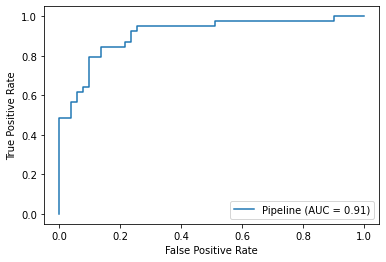

In [63]:
# Print our roc-auc curve
plot_roc_curve(clf_bal, X_hold, y_hold)

### Now - Let's Build an Evaluate Function for Classification!

In [118]:
def evaluate(estimator, X_train, X_test, y_train, y_test, roc_auc='skip'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score'
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba':
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'.")
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format=',.5g')
    plt.show()
    
    if type(train_out) == np.ndarray: # checking for roc_auc
        plot_roc_curve(estimator, X_test, y_test)
        plt.show()

Train Scores
------------
Accuracy: 0.8202247191011236
F1 Score: 0.7707006369426751
ROC-AUC: 0.8657832650734953
--------------------
Test Scores
-----------
Accuracy: 0.8222222222222222
F1 Score: 0.8048780487804877
ROC-AUC: 0.9095022624434389


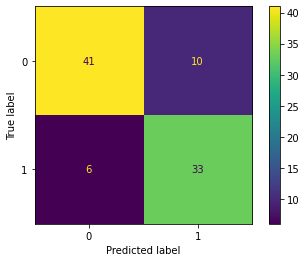

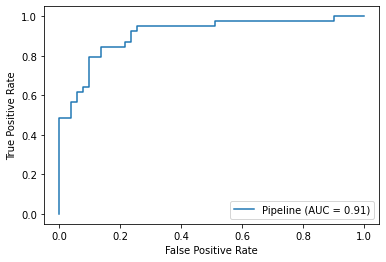

In [119]:
evaluate(clf_bal, X_train, X_hold, y_train, y_hold, roc_auc='proba')

### Bonus Visualization

Code originated from: https://stackoverflow.com/questions/45715018/scikit-learn-how-to-plot-probabilities

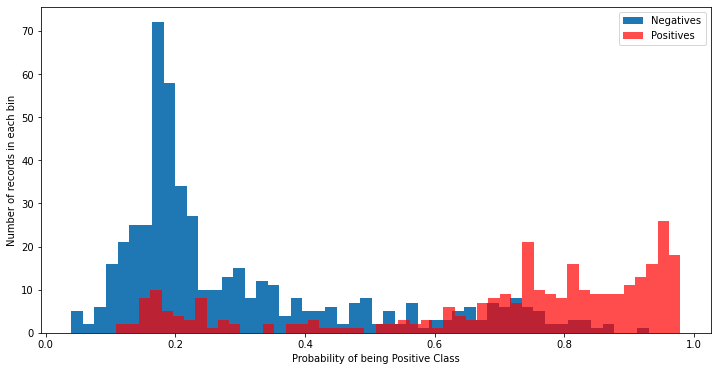

In [54]:
# One last thing...
train_target = pd.DataFrame(y_train) # Create a df with our actual train y values
# Add the predicted probabilities for 1 as a column
train_target['Predicted Probability'] = clf_bal.predict_proba(X_train)[:,1]

# Plot the two
plt.figure(figsize=(12,6))
plt.hist(train_target[train_target['Survived']==0]['Predicted Probability'], 
         bins=50, label='Negatives')
plt.hist(train_target[train_target['Survived']==1]['Predicted Probability'], 
         bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bin')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

## Resources

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)